In [ ]:
# ============================================================
# SETUP
# ============================================================
!pip install -q scikit-learn seaborn

import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
# ============================================================
# LOAD DATA
# ============================================================
df = pd.read_csv("/content/all-data.csv", encoding='latin1')

df.columns = ["label", "text"]
df["text"] = df["text"].astype(str)

print("Shape:", df.shape)
df.head()

Shape: (4845, 2)


,label,text
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [ ]:
import re

def clean_text(text):
    # Remove non-alphanumeric characters and replace with space
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

print("Đã làm sạch cột 'text'. Vui lòng chạy lại các ô tiếp theo để đảm bảo mô hình sử dụng dữ liệu đã được làm sạch.")
display(df.head())

Đã làm sạch cột 'text'. Vui lòng chạy lại các ô tiếp theo để đảm bảo mô hình sử dụng dữ liệu đã được làm sạch.


,label,text
0,neutral,technopolis plans to develop in stages an area...
1,negative,the international electronic industry company ...
2,positive,with the new production plant the company woul...
3,positive,according to the company s updated strategy fo...
4,positive,financing of aspocomp s growth aspocomp is agg...


label
neutral     2878
positive    1363
negative     604
Name: count, dtype: int64


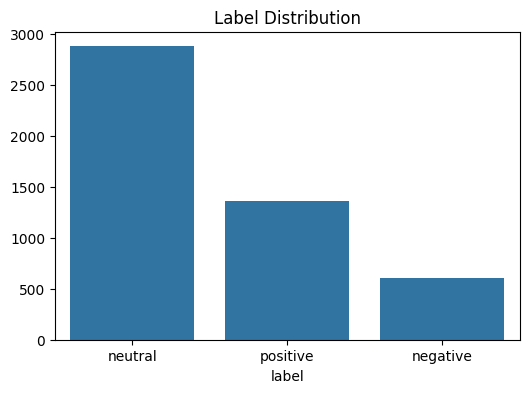

In [ ]:
label_counts = df["label"].value_counts()
print(label_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution")
plt.show()

Mean length: 21.298039215686273
Median length: 20.0


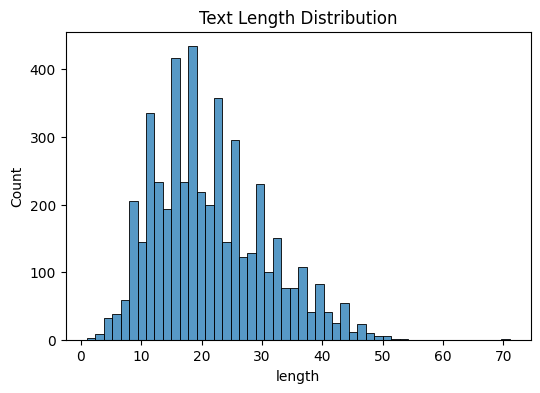

In [ ]:
df["length"] = df["text"].apply(lambda x: len(x.split()))

print("Mean length:", df["length"].mean())
print("Median length:", df["length"].median())

plt.figure(figsize=(6,4))
sns.histplot(df["length"], bins=50)
plt.title("Text Length Distribution")
plt.show()

In [ ]:
label2id = {label: i for i, label in enumerate(df["label"].unique())}
id2label = {v: k for k, v in label2id.items()}

df["label_id"] = df["label"].map(label2id)

print(label2id)

{'neutral': 0, 'negative': 1, 'positive': 2}


In [ ]:
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df["label_id"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.6667, stratify=temp_df["label_id"], random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (3391, 4)
Val: (484, 4)
Test: (970, 4)


In [ ]:
def build_vocab(texts, max_vocab=20000):
    counter = Counter()
    for text in texts:
        counter.update(text.lower().split())
    vocab = counter.most_common(max_vocab-2)
    word2idx = {"<PAD>":0, "<UNK>":1}
    for i,(word,_) in enumerate(vocab):
        word2idx[word] = i+2
    return word2idx

word2idx = build_vocab(train_df["text"])
vocab_size = len(word2idx)

print("Vocabulary size:", vocab_size)

Vocabulary size: 8338


In [ ]:
MAX_LEN = 100

def encode(text, word2idx):
    tokens = text.lower().split()
    ids = [word2idx.get(t, 1) for t in tokens]
    ids = ids[:MAX_LEN]
    ids += [0]*(MAX_LEN-len(ids))
    return ids

class TextDataset(Dataset):
    def __init__(self, df):
        self.texts = df["text"].tolist()
        self.labels = df["label_id"].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = torch.tensor(encode(self.texts[idx], word2idx))
        y = torch.tensor(self.labels[idx])
        return x, y

In [ ]:
BATCH_SIZE = 64

train_loader = DataLoader(TextDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TextDataset(val_df), batch_size=BATCH_SIZE)
test_loader = DataLoader(TextDataset(test_df), batch_size=BATCH_SIZE)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) *
                        -(math.log(10000.0)/d_model))

        pe[:, 0::2] = torch.sin(pos*div)
        pe[:, 1::2] = torch.cos(pos*div)

        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.size()

        q = self.q(x).view(B,T,self.n_heads,self.d_k).transpose(1,2)
        k = self.k(x).view(B,T,self.n_heads,self.d_k).transpose(1,2)
        v = self.v(x).view(B,T,self.n_heads,self.d_k).transpose(1,2)

        scores = (q @ k.transpose(-2,-1)) / math.sqrt(self.d_k)
        attn = torch.softmax(scores, dim=-1)
        out = attn @ v

        out = out.transpose(1,2).contiguous().view(B,T,C)
        return self.out(out)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm1(x + self.dropout(self.attn(x)))
        x = self.norm2(x + self.dropout(self.ff(x)))
        return x

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes,
                 d_model=128, n_heads=4, n_layers=2, d_ff=256):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model)

        self.layers = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff)
            for _ in range(n_layers)
        ])

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos(x)

        for layer in self.layers:
            x = layer(x)

        x = x.mean(dim=1)
        return self.classifier(x)

In [ ]:
model = TransformerClassifier(
    vocab_size=vocab_size,
    num_classes=len(label2id)
).to(device)

print("Total parameters:", sum(p.numel() for p in model.parameters()))

Total parameters: 1332611


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

EPOCHS = 15

In [ ]:
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x,y in train_loader:
        x,y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits,y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss {total_loss/len(train_loader):.4f}")

train_time = time.time() - start_time
print("Training time (seconds):", train_time)

Epoch 1 | Loss 0.3455
Epoch 2 | Loss 0.2931
Epoch 3 | Loss 0.2507
Epoch 4 | Loss 0.1995
Epoch 5 | Loss 0.1654
Epoch 6 | Loss 0.1335
Epoch 7 | Loss 0.1160
Epoch 8 | Loss 0.0952
Epoch 9 | Loss 0.0684
Epoch 10 | Loss 0.0572
Epoch 11 | Loss 0.0492
Epoch 12 | Loss 0.0358
Epoch 13 | Loss 0.0299
Epoch 14 | Loss 0.0240
Epoch 15 | Loss 0.0216
Training time (seconds): 337.91322207450867


In [ ]:
def evaluate(loader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            p = torch.argmax(logits, dim=1)

            preds.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return np.array(labels), np.array(preds)

In [ ]:
y_true, y_pred = evaluate(test_loader)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Macro F1:", f1_score(y_true, y_pred, average="macro"))
print("Weighted F1:", f1_score(y_true, y_pred, average="weighted"))

Accuracy: 0.6979381443298969
Macro F1: 0.62874608093589
Weighted F1: 0.6928567618023942


In [ ]:
print(classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(len(id2label))]
))

              precision    recall  f1-score   support

     neutral       0.76      0.81      0.78       576
    negative       0.57      0.50      0.53       121
    positive       0.60      0.54      0.57       273

    accuracy                           0.70       970
   macro avg       0.64      0.62      0.63       970
weighted avg       0.69      0.70      0.69       970



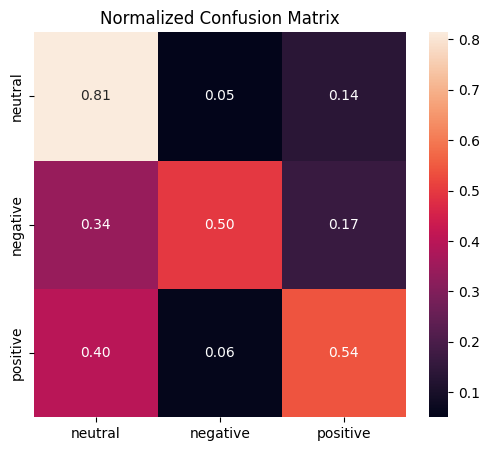

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize="true")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".2f",
            xticklabels=id2label.values(),
            yticklabels=id2label.values())
plt.title("Normalized Confusion Matrix")
plt.show()

In [ ]:
model_size = sum(p.numel() for p in model.parameters()) * 4 / 1024**2
print("Model size (MB):", model_size)

Model size (MB): 5.083507537841797
